In [16]:
import pandas as pd
import re
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
%matplotlib inline
import keras
#from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, GRU, Embedding
from keras.layers import Activation, Bidirectional, GlobalMaxPool1D, GlobalMaxPool2D, Dropout
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,PorterStemmer
import seaborn as sns
import transformers
from transformers import AutoTokenizer
from tokenizers import BertWordPieceTokenizer
from keras.initializers import Constant
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from collections import Counter
from keras.utils import pad_sequences
from keras.optimizers import adam_v2
nltk.download('stopwords')
stop=set(stopwords.words('english'))

import os


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/arthurlamard/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Functions

The actual tweets are stored in the text column. Each tweet has an associated sentiment, as well as a support phrase stored in the select_text column (the part of the tweet that serves as the basis for the sentiment assignment decision).
We start by defining the basic cleanup functionality. First, we remove URLs and non-characters from websites and replace the stars that people use in place of swear words with a single token "swear". We use some regular expressions to help us do this.

In [17]:


def basic_cleaning(text):
    text=re.sub(r'https?://www\.\S+\.com','',text)
    text=re.sub(r'[^A-Za-z|\s]','',text)
    text=re.sub(r'\*+','swear',text) # remove ** by swear 
    return text

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)


def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  
                           u"\U0001F300-\U0001F5FF"  
                           u"\U0001F680-\U0001F6FF"  
                           u"\U0001F1E0-\U0001F1FF"  
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
# Finally, we want to be able to remove duplicate characters (for example, so we have "way" instead of "waaaayyyyy").
def remove_multiplechars(text):
    text = re.sub(r'(.)\1{3,}',r'\1', text)
    return text

# For convenience, we have combined these four functions into a single cleanup function.
def clean(df):
    for col in ['text']:#,'selected_text']:
        df[col]=df[col].astype(str).apply(lambda x:basic_cleaning(x))
        df[col]=df[col].astype(str).apply(lambda x:remove_emoji(x))
        df[col]=df[col].astype(str).apply(lambda x:remove_html(x))
        df[col]=df[col].astype(str).apply(lambda x:remove_multiplechars(x))

    return df

The last bit of preparation consists of writing functions for creating embeddings based on pre-trained models (tagger parameters).

In [18]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=128):    
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen)
    all_ids = []
    
    for i in range(0, len(texts), chunk_size):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

Next, we create a preprocessor function that allows us to process the entire corpus.

In [19]:
def preprocess_news(df,stop=stop,n=1,col='text'):
    '''Function to preprocess and create corpus'''
    new_corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for text in df[col]:
        words=[w for w in word_tokenize(text) if (w not in stop)]
       
        words=[lem.lemmatize(w) for w in words if(len(w)>n)]
     
        new_corpus.append(words)
        
    new_corpus=[word for l in new_corpus for word in l]
    return new_corpus

In [20]:
df = pd.read_csv('./kaggle/input/tweet-sentiment-extraction/train.csv')
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


# Data


We remove the NaN values and use 4 helper functions to clean up the data. These are.
1. basic_cleaning - removes website URLs, non-characters, and replaces the '*****' expletive with the word swear
2. remove_html
3. remove_emojis
4. remove_multiplechars - when a word has more than 3 characters in a line, for example wayyyyy. this function removes all but one letter of the alphabet

The data is then ready for initial exploration

Using the function we prepared before, we can clean and prepare the training data. The sentiment column is our target, and for performance we convert it to a dummy variable (unique heat encoding)

In [21]:
df.dropna(inplace=True)

df_clean = clean(df)


## EDA

In this section, let's take a look at.
1. the distribution of the number of tweets by sentiment.
Positive, neutral and negative groups are more balanced
2. the distribution of tweet length with sentiment.
On the surface, the length of tweets does not seem to vary much.
3. The most common words.
Like appears in the top 10 in all three groups. Given that it is in all three groups, we will not remove it because it will still provide information in a single sequence.

In [22]:
shape = df_clean.shape
print(f"There are {shape[0]} tweets in the dataset")

There are 27480 tweets in the dataset


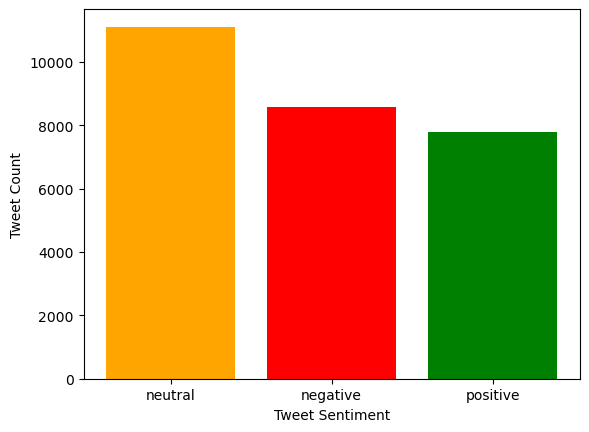

In [23]:
colors=['orange','red','green']
plt.bar(df.sentiment.unique(),df.sentiment.value_counts(), color=colors);
plt.xlabel('Tweet Sentiment');
plt.ylabel('Tweet Count');

Text(0.5, 0.98, 'Distribution of number Words in Tweets')

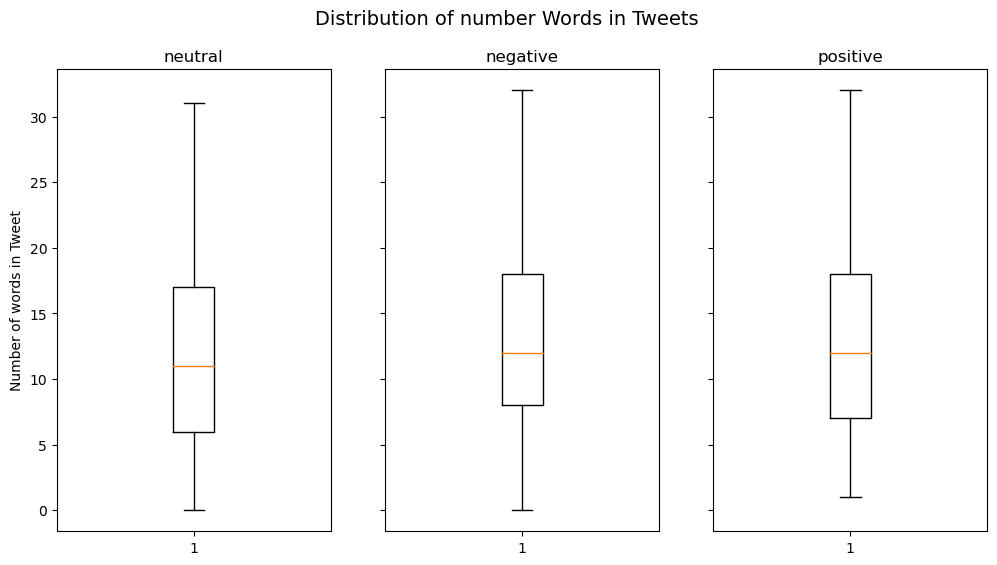

In [24]:
sent=df.sentiment.unique()
fig,ax= plt.subplots(1,3,figsize=(12,6),sharey=True)
for i in range(0,3):
    lengths = df_clean[df_clean['sentiment']==sent[i]]['text'].str.split().str.len()
    ax[i].boxplot(lengths)
    ax[i].set_title(sent[i])
ax[0].set_ylabel('Number of words in Tweet')
fig.suptitle("Distribution of number Words in Tweets", fontsize=14)

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/arthurlamard/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/arthurlamard/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/arthurlamard/nltk_data...


Text(0.5, 0.98, 'Common words in tweet text')

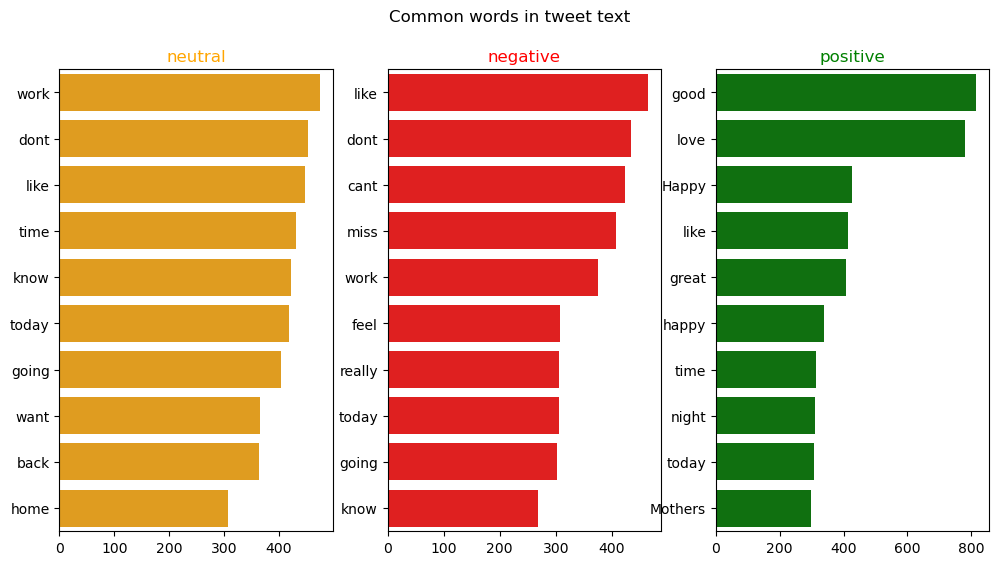

In [27]:
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('wordnet')
nltk.data.path.append('./kaggle/input/nltk-data/nltk_data')
fig,ax=plt.subplots(1,3,figsize=(12,6))
for i in range(3):
    new=df_clean[df_clean['sentiment']==sent[i]]
    corpus_train=preprocess_news(new,n=3)
    counter=Counter(corpus_train)
    most=counter.most_common()
    x=[]
    y=[]
    for word,count in most[:10]:
        if (word not in stop) :
            x.append(word)
            y.append(count)
    sns.barplot(x=y,y=x,ax=ax[i],color=colors[i])
    ax[i].set_title(sent[i],color=colors[i])
fig.suptitle("Common words in tweet text")

## Preprocessing

As for the tags, we encode the targets uniquely hot, tokenize them, and convert them to sequences.

In [28]:
df_clean_selection = df_clean.sample(frac=1)
X = df_clean_selection.text.values
y = pd.get_dummies(df_clean_selection.sentiment)

The next necessary step is the tokenization of the input text, as well as the conversion to a sequence (along with padding to ensure that the entire data set is of equal length).

In [29]:
tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(X))
list_tokenized_train = tokenizer.texts_to_sequences(X)
X_t = pad_sequences(list_tokenized_train, maxlen=128)

# The model: DistilBert

Now we turn our attention to pre-trained embeddings. In this case, we download and use DistilBERT instead of training our own embedding layer. distilBert is a lite version of google's game-changing NLP model BERT, which provides us with a tokenizer and an embedding matrix. the BERT base uncase is trained on lowercase English text, which has about 110 million parameters (768 dimensions per word embedding, a vocabulary of 143,000 words). distilBERT is 60% of the former, but still maintains a 97% performance compared to BERT.

For the purpose of this example, we will keep this matrix instead of training it, because it is large and we will have impractical training time.

In [31]:
tokenizer = transformers.AutoTokenizer.from_pretrained("distilbert-base-uncased")  ## change it to commit

# 将加载的标记器保存在本地
save_path = './kaggle/working/distilbert_base_uncased/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
tokenizer.save_pretrained(save_path)

# 用huggingface tokenizers库重新加载它

fast_tokenizer = BertWordPieceTokenizer('distilbert_base_uncased/vocab.txt', lowercase=True)
fast_tokenizer

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=True, wordpieces_prefix=##)

We can use the fast_encode function defined previously, and the fast_tokenizer defined above, to encode the tweets.

In [32]:
X = fast_encode(df_clean_selection.text.astype(str), fast_tokenizer, maxlen=128)
X.shape

(27480, 128)

Once the data is prepared, we can build the model. In this demo, we will use a fairly standard architecture for these applications: a combination of LSTM layers, normalized by global pools and dropouts, with a dense layer on top. To achieve a really competitive solution, some adjustments to the architecture are needed: a "heavier" model, larger embeddings, more cells in the LSTM layer, etc.

In [33]:
transformer_layer = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


2023-05-30 14:09:09.148439: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification mode

In [34]:
embedding_size = 128
input_ = Input(shape=(100,))

inp = Input(shape=(128, ))
#inp2= Input(shape=(1,))

embedding_matrix=transformer_layer.weights[0].numpy()

x = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],embeddings_initializer=Constant(embedding_matrix),trainable=False)(inp)
x = Bidirectional(LSTM(50, return_sequences=True))(x)
x = Bidirectional(LSTM(25, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.5)(x)
x = Dense(50, activation='relu', kernel_regularizer='L1L2')(x)
x = Dropout(0.5)(x)
x = Dense(3, activation='softmax')(x)

model_DistilBert = Model(inputs=[inp], outputs=x)

There is no particular need to pay attention to the temporal dimension of the data, so we can randomly split it into training and validation, which can be achieved when calling the fit method

In [35]:
model_DistilBert.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [36]:
model_DistilBert.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding (Embedding)       (None, 128, 768)          23440896  
                                                                 
 bidirectional (Bidirectiona  (None, 128, 100)         327600    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128, 50)          25200     
 nal)                                                            
                                                                 
 global_max_pooling1d (Globa  (None, 50)               0         
 lMaxPooling1D)                                                  
                                                             

In [37]:
model_DistilBert.fit(X,y,batch_size=32,epochs=10,validation_split=0.1) 
#model_DistilBert.fit(X,y,batch_size=32,epochs=1,validation_split=0.1) 

Epoch 1/10
773/773 [==============================] - 125s 154ms/step - loss: 1.0528 - accuracy: 0.4367 - val_loss: 0.8431 - val_accuracy: 0.5997
Epoch 2/10
773/773 [==============================] - 123s 159ms/step - loss: 0.7573 - accuracy: 0.6820 - val_loss: 0.6466 - val_accuracy: 0.7311
Epoch 3/10
773/773 [==============================] - 124s 161ms/step - loss: 0.6617 - accuracy: 0.7322 - val_loss: 0.6143 - val_accuracy: 0.7424
Epoch 4/10
773/773 [==============================] - 125s 162ms/step - loss: 0.6271 - accuracy: 0.7473 - val_loss: 0.5982 - val_accuracy: 0.7511
Epoch 5/10
773/773 [==============================] - 127s 165ms/step - loss: 0.6065 - accuracy: 0.7595 - val_loss: 0.5923 - val_accuracy: 0.7507
Epoch 6/10
773/773 [==============================] - 129s 166ms/step - loss: 0.5868 - accuracy: 0.7656 - val_loss: 0.5881 - val_accuracy: 0.7609
Epoch 7/10
773/773 [==============================] - 129s 167ms/step - loss: 0.5675 - accuracy: 0.7760 - val_loss: 0.5787 -

As you can see from the output above, the model converges fairly quickly and has already achieved a reasonable accuracy of 76% on the validation set after 10 iterations. Further fine-tuning of hyperparameters and longer training times could improve performance, but even at this level, a trained model - for example by using TensorFlow Serving - can provide a valuable addition to sentiment analysis logic for commercial applications.

Generating predictions from the fitted model is done in a straightforward manner. To take advantage of all available data, we first retrain our model on all available data (so there is no validation).

# Extrapolation

In [38]:
df_clean_final = df_clean.sample(frac=1)
X_train = fast_encode(df_clean_selection.text.astype(str), fast_tokenizer, maxlen=128)
y_train = y

We re-match the model on the entire dataset before generating prediction results.

In [39]:
Adam_name = adam_v2.Adam(lr=0.001)
model_DistilBert.compile(loss='categorical_crossentropy',optimizer=Adam_name,metrics=['accuracy'])
history = model_DistilBert.fit(X_train,y_train,batch_size=32,epochs=10)

Epoch 1/10


/Users/arthurlamard/Documents/Allemagne/cours/Big_Data/.conda/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


859/859 [==============================] - 148s 166ms/step - loss: 0.5093 - accuracy: 0.8033
Epoch 2/10
859/859 [==============================] - 132s 153ms/step - loss: 0.4862 - accuracy: 0.8112
Epoch 3/10
859/859 [==============================] - 136s 158ms/step - loss: 0.4716 - accuracy: 0.8178
Epoch 4/10
859/859 [==============================] - 139s 162ms/step - loss: 0.4496 - accuracy: 0.8269
Epoch 5/10
859/859 [==============================] - 139s 162ms/step - loss: 0.4303 - accuracy: 0.8336
Epoch 6/10
859/859 [==============================] - 141s 164ms/step - loss: 0.4117 - accuracy: 0.8447
Epoch 7/10
859/859 [==============================] - 140s 163ms/step - loss: 0.3853 - accuracy: 0.8564
Epoch 8/10
859/859 [==============================] - 138s 161ms/step - loss: 0.3658 - accuracy: 0.8650
Epoch 9/10
859/859 [==============================] - 137s 159ms/step - loss: 0.3358 - accuracy: 0.8764
Epoch 10/10
859/859 [==============================] - 138s 161ms/step - lo

Our next step is to process the test data into the same format as the training data of the input model.

In [41]:
df_test = pd.read_csv('./kaggle/input/tweet-sentiment-extraction/test.csv')
df_test.dropna(inplace=True)
df_clean_test = clean(df_test)

X_test = fast_encode(df_clean_test.text.values.astype(str), fast_tokenizer, maxlen=128)
y_test = df_clean_test.sentiment

Finally, we generate the prediction results.

In [42]:
y_preds = model_DistilBert.predict(X_test)
y_predictions = pd.DataFrame(y_preds, columns=['negative','neutral','positive'])
y_predictions_final = y_predictions.idxmax(axis=1)
accuracy = accuracy_score(y_test,y_predictions_final)
print(f"The final model shows {accuracy:.2f} accuracy on the test set.")

111/111 [==============================] - 9s 70ms/step
The final model shows 0.75 accuracy on the test set.


The final model shows an accuracy of 0.75 on the test set. Below we show a sample of the results; you can see in these lines that in some cases the human reader's emotion is evident, but the model does not capture it.

In [46]:
display = df_clean_test.copy()
y_predictions.columns = ['predicted_' + f for f in y_predictions.columns]
predict = pd.concat([display, y_predictions], axis = 1).head(10)
predict

,textID,text,sentiment,predicted_predicted_predicted_negative,predicted_predicted_predicted_neutral,predicted_predicted_predicted_positive
0,f87dea47db,Last session of the day httptwitpiccomezh,neutral,3.469061e-03,0.991960,4.571353e-03
1,96d74cb729,Shanghai is also really exciting precisely s...,positive,1.287650e-08,0.001628,9.983725e-01
2,eee518ae67,Recession hit Veronique Branquinho she has to ...,negative,9.998928e-01,0.000107,1.041350e-10
3,01082688c6,happy bday,positive,1.322673e-07,0.001670,9.983296e-01
4,33987a8ee5,httptwitpiccomwp I like it,positive,5.082700e-06,0.012027,9.879677e-01
5,726e501993,thats great weee visitors,positive,7.464822e-07,0.006457,9.935426e-01
6,261932614e,I THINK EVERYONE HATES ME ON HERE lol,negative,8.267790e-01,0.170732,2.488601e-03
7,afa11da83f,so wish i could but im in school and myspace ...,negative,9.430550e-01,0.056685,2.596085e-04
8,e64208b4ef,and within a short time of the last clue all ...,neutral,1.561200e-03,0.997404,1.035213e-03
9,37bcad24ca,What did you get My day is alright havent do...,neutral,7.527336e-02,0.908981,1.574603e-02


In [45]:
predict_file=predict.to_csv("submission.csv", index=False)